In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.datasets import get_rdataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Beautiful plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
%matplotlib inline

# Load Airline Passengers dataset
data = get_rdataset('AirPassengers', 'datasets').data
data['time'] = pd.date_range(start='1949-01', periods=len(data), freq='M')
data.set_index('time', inplace=True)
data = data['value']
data.name = 'passengers'

print(data.head())
print(f"\nDataset: {len(data)} monthly observations from 1949 to 1960")

time
1949-01-31    112
1949-02-28    118
1949-03-31    132
1949-04-30    129
1949-05-31    121
Name: passengers, dtype: int64

Dataset: 144 monthly observations from 1949 to 1960


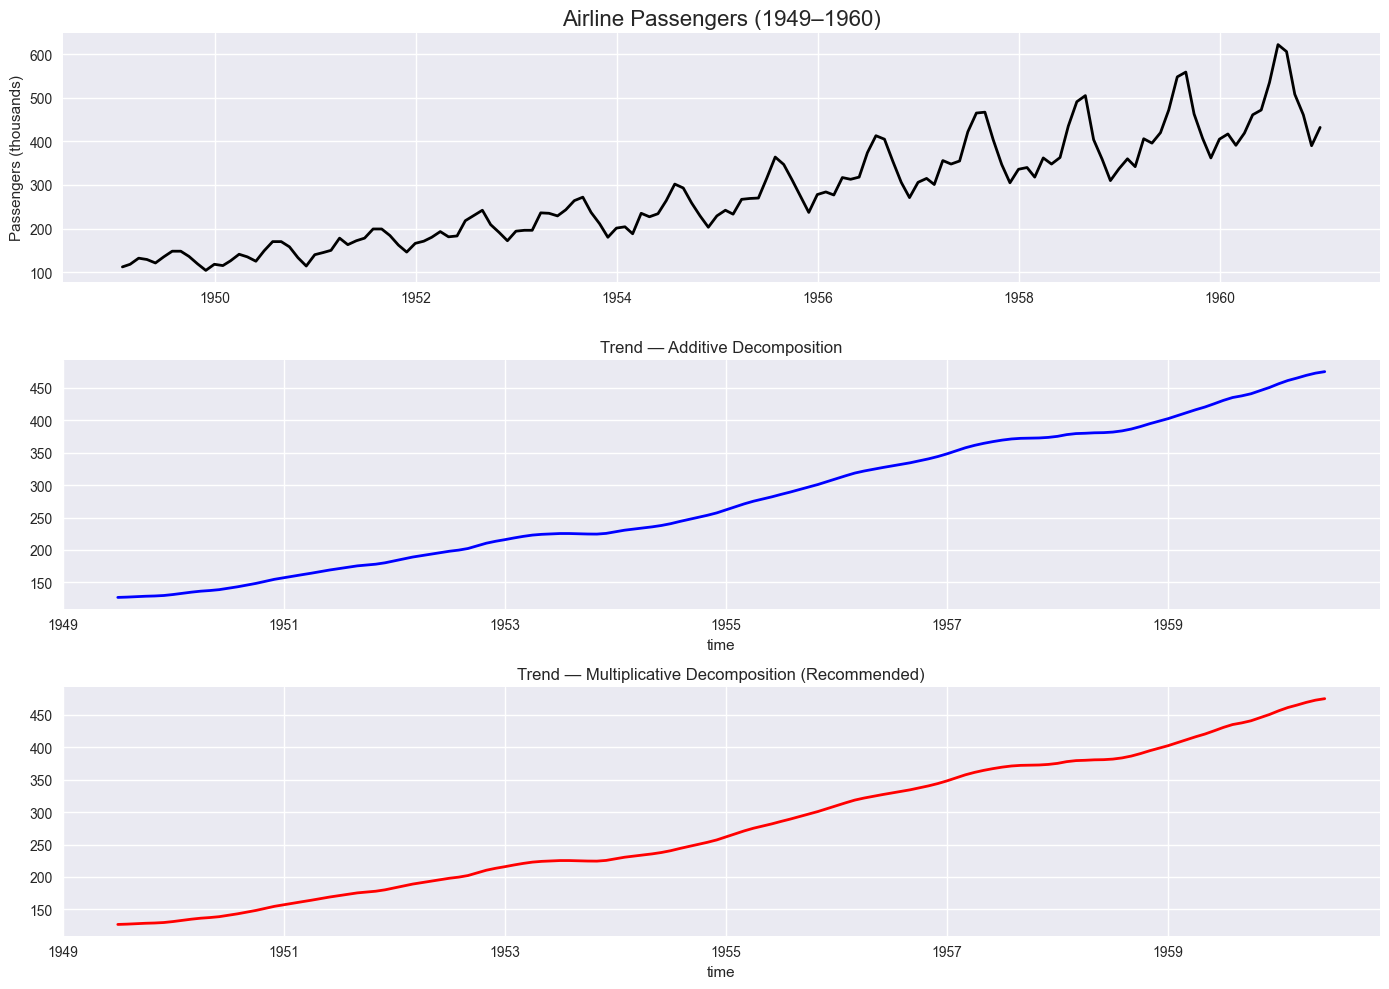

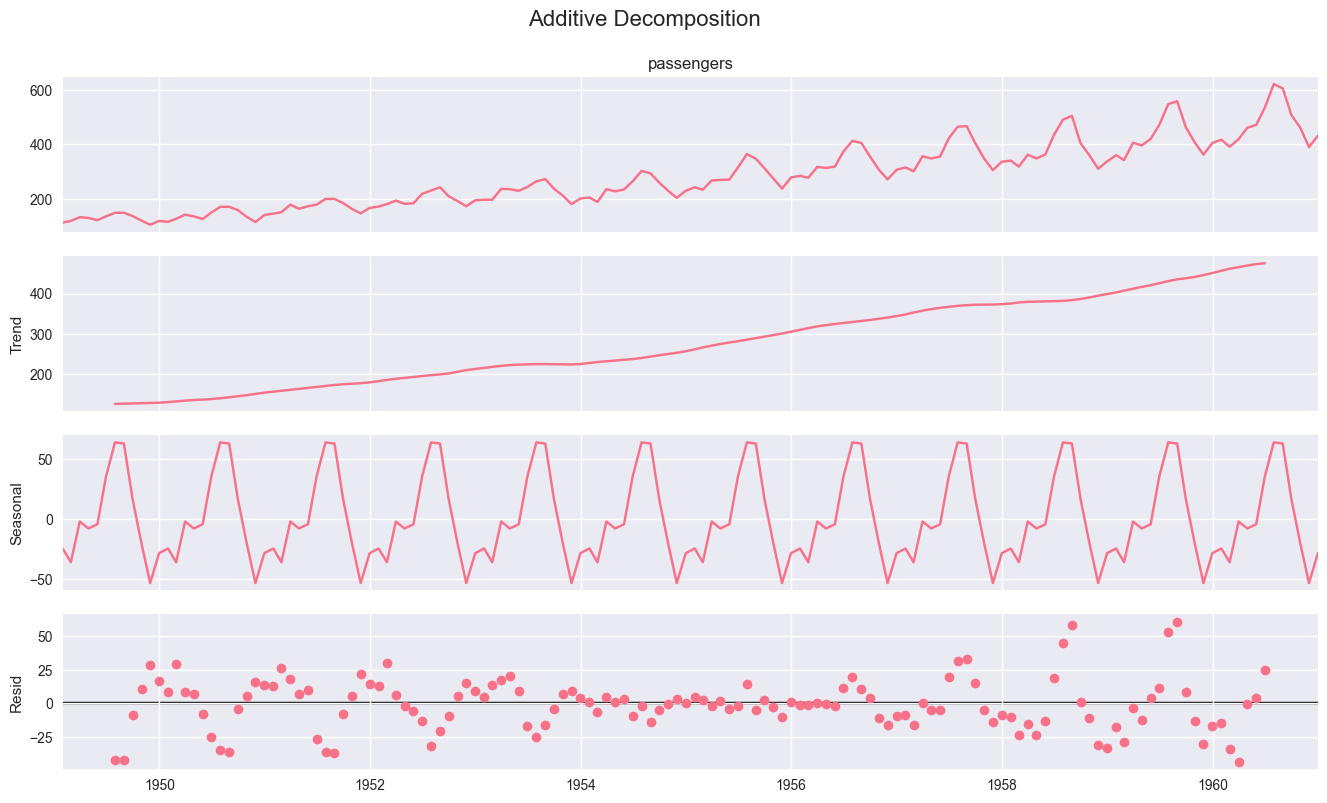

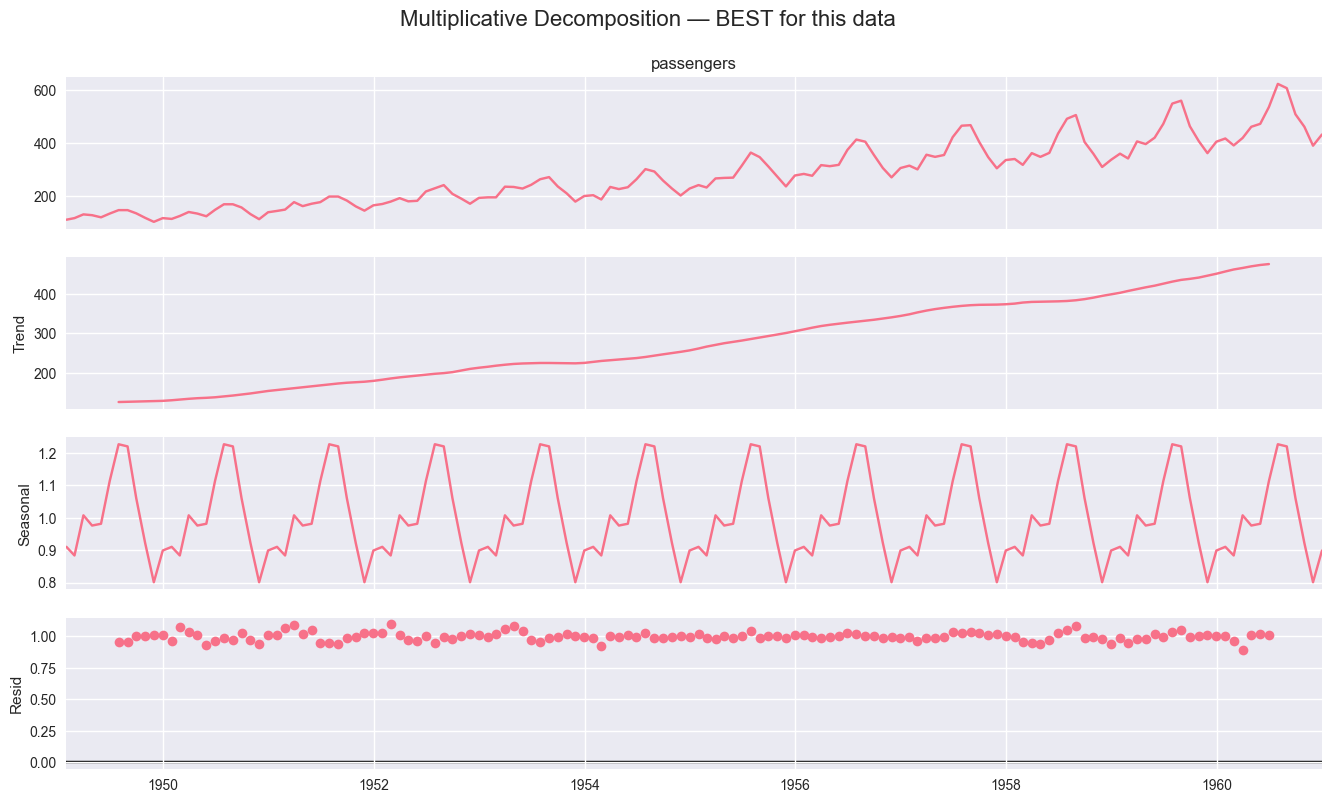

In [55]:
# Full decomposition (multiplicative is better here!)
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Original series
axes[0].plot(data, color='black', linewidth=2)
axes[0].set_title('Airline Passengers (1949–1960)', fontsize=16)
axes[0].set_ylabel('Passengers (thousands)')

# Additive decomposition trend
decomp_add = seasonal_decompose(data, model='additive', period=12)
decomp_add.trend.plot(ax=axes[1], color='blue', linewidth=2)
axes[1].set_title('Trend — Additive Decomposition')

# Multiplicative decomposition trend
decomp_mult = seasonal_decompose(data, model='multiplicative', period=12)
decomp_mult.trend.plot(ax=axes[2], color='red', linewidth=2)
axes[2].set_title('Trend — Multiplicative Decomposition (Recommended)')

plt.tight_layout()
plt.show()

# Full plots
decomp_add.plot().set_size_inches(14, 8)
plt.suptitle('Additive Decomposition', fontsize=16, y=1.02)
plt.show()

decomp_mult.plot().set_size_inches(14, 8)
plt.suptitle('Multiplicative Decomposition — BEST for this data', fontsize=16, y=1.02)
plt.show()

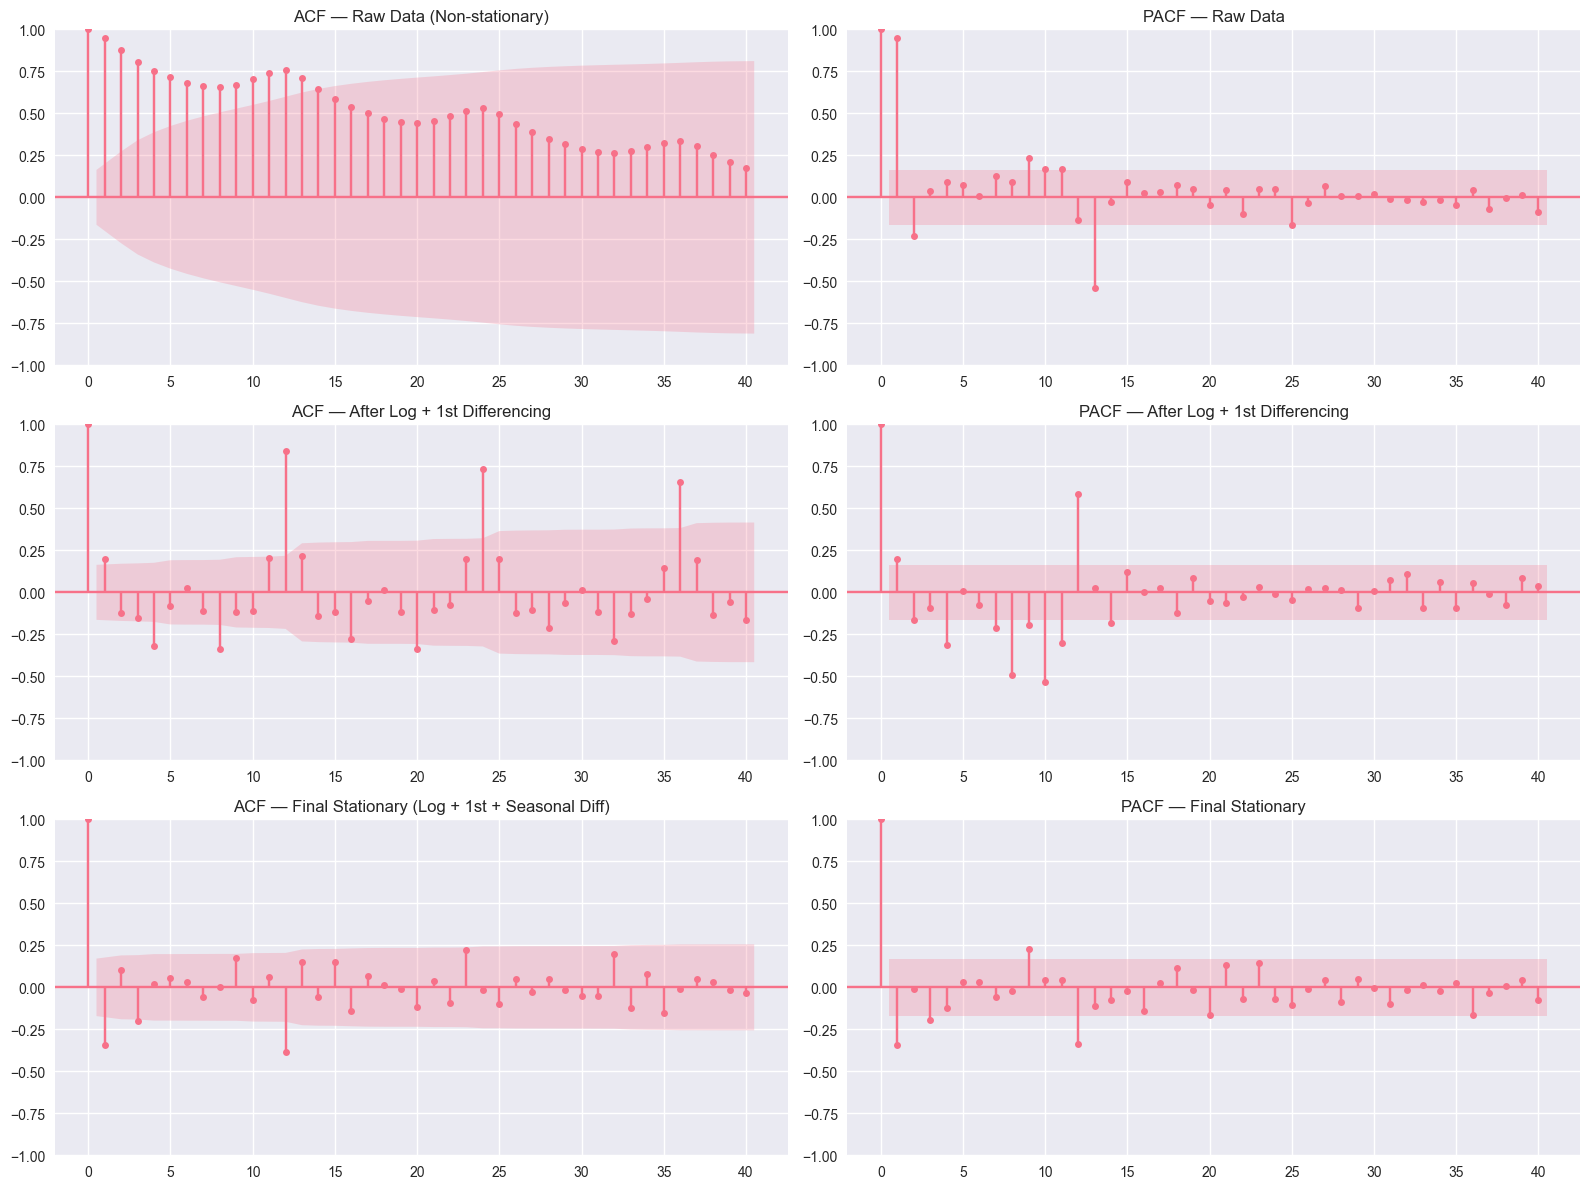

In [35]:
# Transformations
data_log = np.log(data)
data_log_diff = data_log.diff().dropna()
stationary = data_log_diff.diff(12).dropna()  # Final stationary series

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Raw data
plot_acf(data, lags=40, ax=axes[0,0], title='ACF — Raw Data (Non-stationary)')
plot_pacf(data, lags=40, ax=axes[0,1], title='PACF — Raw Data')

# After log + first differencing
plot_acf(data_log_diff, lags=40, ax=axes[1,0], title='ACF — After Log + 1st Differencing')
plot_pacf(data_log_diff, lags=40, ax=axes[1,1], title='PACF — After Log + 1st Differencing')

# Final stationary series
plot_acf(stationary, lags=40, ax=axes[2,0], title='ACF — Final Stationary (Log + 1st + Seasonal Diff)')
plot_pacf(stationary, lags=40, ax=axes[2,1], title='PACF — Final Stationary')

plt.tight_layout()
plt.show()

In [51]:
# =============================================================================
# TRAIN-TEST SPLIT AND DATA PREPARATION
# =============================================================================

train_size = int(len(data) * 0.8)
train_log = np.log(data[:train_size])
test_log = np.log(data[train_size:])
test_original = data[train_size:]

print(f"Train size: {len(train_log)} observations")
print(f"Test size: {len(test_log)} observations")

# Exogenous trend (helps ARIMAX a bit)
trend = np.arange(len(data)) / 12.0
exog_train = trend[:train_size].reshape(-1, 1)
exog_test = trend[train_size:].reshape(-1, 1)


print(f"\nData prepared for modeling.")

Train size: 115 observations
Test size: 29 observations

Data prepared for modeling.


In [37]:
# =============================================================================
# STEP 1: FIND OPTIMAL PARAMETERS WITH AUTO_ARIMA
# =============================================================================
# IMPORTANT: We use auto_arima FIRST to find the best hyperparameters
# This prevents model misspecification and convergence issues

print("="*80)
print("STEP 1: HYPERPARAMETER OPTIMIZATION WITH AUTO_ARIMA")
print("="*80)

try:
    import pmdarima as pm
    from pmdarima import auto_arima
    
    print("\nSearching for optimal SARIMAX parameters using auto_arima...")
    print("(This may take a few minutes)\n")
    
    # Auto ARIMA with exogenous variables
    # This will find the best (p,d,q)(P,D,Q,s) combination
    auto_model = auto_arima(
        train_log,
        exogenous=exog_train,
        start_p=0, start_q=0,
        max_p=3, max_q=3,
        seasonal=True,
        m=12,  # Monthly data (seasonal period = 12)
        start_P=0, start_Q=0,
        max_P=2, max_Q=2,
        max_d=2, max_D=1,
        stepwise=True,  # Uses stepwise selection (faster)
        suppress_warnings=True,
        error_action='ignore',
        trace=True,  # Show progress
        information_criterion='aic',  # Use AIC for model selection
        random_state=42,
        n_jobs=1
    )
    
    print("\n" + "="*80)
    print("OPTIMAL MODEL FOUND BY AUTO_ARIMA:")
    print("="*80)
    print(auto_model.summary())
    
    # Get the optimal order
    optimal_order = auto_model.order
    optimal_seasonal_order = auto_model.seasonal_order
    
    print(f"\n✓ Optimal Order (p,d,q): {optimal_order}")
    print(f"✓ Optimal Seasonal Order (P,D,Q,s): {optimal_seasonal_order}")
    print(f"✓ AIC: {auto_model.aic():.2f}")
    
    # Store for later use
    best_order = optimal_order
    best_seasonal_order = optimal_seasonal_order
    
except ImportError:
    print("⚠ pmdarima not available. Using default parameters.")
    print("You can install it with: pip install pmdarima")
    best_order = (1, 1, 1)
    best_seasonal_order = (1, 1, 1, 12)
    auto_model = None
except Exception as e:
    print(f"⚠ Auto ARIMA search failed: {e}")
    print("Using default parameters as fallback.")
    best_order = (1, 1, 1)
    best_seasonal_order = (1, 1, 1, 12)
    auto_model = None

print("\n" + "="*80)
print("Next: Fitting models with optimal parameters...")
print("="*80)


STEP 1: HYPERPARAMETER OPTIMIZATION WITH AUTO_ARIMA

Searching for optimal SARIMAX parameters using auto_arima...
(This may take a few minutes)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-271.901, Time=0.04 sec


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-366.335, Time=1.66 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-335.954, Time=0.68 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-108.879, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-348.304, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-372.803, Time=2.79 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-371.323, Time=2.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-286.147, Time=2.08 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-374.925, Time=2.41 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-371.069, Time=1.16 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=-373.103, Time=1.96 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=-373.010, Time=2.56 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=-373.069, Time=2.86 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-373.145, Time=2.66 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-374.369, Time=2.52 sec


In [38]:
# =============================================================================
# STEP 2: FIT MODELS WITH ERROR HANDLING
# =============================================================================

print("="*80)
print("STEP 2: FITTING MODELS WITH ERROR DETECTION")
print("="*80)

# Function to check if model converged properly
def check_model_convergence(model, model_name):
    """Check if SARIMAX model converged properly"""
    issues = []
    
    # Check residuals
    residuals = model.resid
    resid_mean = residuals.mean()
    resid_std = residuals.std()
    
    # Check for numerical issues
    if abs(resid_mean) > 1e6:
        issues.append(f"Residual mean is extremely large: {resid_mean:.2e} (should be ~0)")
    
    if resid_std > 1e6:
        issues.append(f"Residual std is extremely large: {resid_std:.2e} (numerical instability)")
    
    # Check for NaN or Inf
    if np.any(np.isnan(residuals)) or np.any(np.isinf(residuals)):
        issues.append("Residuals contain NaN or Inf values")
    
    # Check AIC (should be finite)
    if not np.isfinite(model.aic):
        issues.append(f"AIC is not finite: {model.aic}")
    
    # Check if fitted values make sense
    fitted = model.fittedvalues
    if np.any(np.isnan(fitted)) or np.any(np.isinf(fitted)):
        issues.append("Fitted values contain NaN or Inf")
    
    if len(issues) > 0:
        print(f"\n✗ {model_name} CONVERGENCE FAILURE DETECTED:")
        for issue in issues:
            print(f"  - {issue}")
        return False
    else:
        print(f"\n✓ {model_name} converged successfully")
        print(f"  - Residual mean: {resid_mean:.6f} (should be ~0)")
        print(f"  - Residual std: {resid_std:.4f}")
        print(f"  - AIC: {model.aic:.2f}")
        return True

# =============================================================================
# Fit ARIMAX (no seasonality) - for comparison
# =============================================================================
print("\nFitting ARIMAX(1,1,1) for comparison...")
try:
    arimax = SARIMAX(
        train_log, 
        order=(1,1,1), 
        exog=exog_train,
        enforce_stationarity=True,
        enforce_invertibility=True
    ).fit(disp=False, maxiter=200)
    
    arimax_ok = check_model_convergence(arimax, "ARIMAX(1,1,1)")
    if not arimax_ok:
        print("  → ARIMAX failed to converge properly")
        arimax = None
except Exception as e:
    print(f"✗ ARIMAX fitting failed: {e}")
    arimax = None

# =============================================================================
# Fit SARIMAX with OPTIMAL parameters from auto_arima
# =============================================================================
print(f"\nFitting SARIMAX{best_order}{best_seasonal_order}...")

sarimax = None
sarimax_ok = False

try:
    sarimax = SARIMAX(
        train_log, 
        order=best_order, 
        seasonal_order=best_seasonal_order,
        exog=exog_train,
        enforce_stationarity=True,  # Ensures stationarity
        enforce_invertibility=True,  # Ensures invertibility
        simple_differencing=False    # Use exact differencing
    ).fit(
        disp=False, 
        maxiter=200,
        method='lbfgs',  # Try L-BFGS optimizer
        optim_hessian='approx'  # Use approximate Hessian (faster, more stable)
    )
    
    sarimax_ok = check_model_convergence(sarimax, f"SARIMAX{best_order}{best_seasonal_order}")
    
    if not sarimax_ok:
        print("\n  → Attempting alternative fitting methods...")
        
        # Try with different optimizer
        try:
            sarimax = SARIMAX(
                train_log, 
                order=best_order, 
                seasonal_order=best_seasonal_order,
                exog=exog_train,
                enforce_stationarity=True,
                enforce_invertibility=True
            ).fit(
                disp=False, 
                maxiter=500,
                method='powell'  # Powell method (slower but more robust)
            )
            sarimax_ok = check_model_convergence(sarimax, f"SARIMAX{best_order}{best_seasonal_order} (Powell)")
        except:
            pass
        
        # If still failing, try simpler parameters
        if not sarimax_ok:
            print("\n  → Trying simpler parameters as fallback...")
            try:
                simple_order = (1, 1, 1)
                simple_seasonal = (1, 1, 1, 12)
                sarimax = SARIMAX(
                    train_log, 
                    order=simple_order, 
                    seasonal_order=simple_seasonal,
                    exog=exog_train,
                    enforce_stationarity=True,
                    enforce_invertibility=True
                ).fit(disp=False, maxiter=200)
                sarimax_ok = check_model_convergence(sarimax, f"SARIMAX{simple_order}{simple_seasonal} (fallback)")
                if sarimax_ok:
                    best_order = simple_order
                    best_seasonal_order = simple_seasonal
                    print("  → Using fallback parameters")
            except Exception as e2:
                print(f"  ✗ Fallback also failed: {e2}")

except Exception as e:
    print(f"✗ SARIMAX fitting failed: {e}")
    print(f"  Error type: {type(e).__name__}")
    
    # Provide explanation
    print("\n" + "="*80)
    print("WHY DID SARIMAX FAIL?")
    print("="*80)
    print("Common reasons for SARIMAX convergence failures:")
    print("1. Parameter misspecification: (p,d,q) or (P,D,Q,s) may be wrong")
    print("2. Numerical instability: Very small/large parameter values")
    print("3. Non-stationarity: Data may need different differencing")
    print("4. Exogenous variable issues: Exogenous vars may be collinear or problematic")
    print("5. Insufficient data: Not enough observations for the model complexity")
    print("6. Multiple optima: Optimizer trapped in local minimum")
    print("\nSolution: Use auto_arima (done above) to find better parameters")
    print("="*80)

if sarimax is None or not sarimax_ok:
    print("\n⚠ WARNING: SARIMAX model could not be fitted properly!")
    print("  Continuing with diagnostics may show unrealistic results.")
    print("  Consider:")
    print("    - Removing exogenous variables")
    print("    - Using different transformations")
    print("    - Trying different (p,d,q) parameters manually")
else:
    print("\n✓ SARIMAX model fitted successfully with optimal parameters!")


STEP 2: FITTING MODELS WITH ERROR DETECTION

Fitting ARIMAX(1,1,1) for comparison...

✓ ARIMAX(1,1,1) converged successfully
  - Residual mean: 0.041004 (should be ~0)
  - Residual std: 0.4509
  - AIC: -196.70

Fitting SARIMAX(2, 0, 0)(2, 1, 0, 12)...

✓ SARIMAX(2, 0, 0)(2, 1, 0, 12) converged successfully
  - Residual mean: 0.498532 (should be ~0)
  - Residual std: 1.4681
  - AIC: -374.93

✓ SARIMAX model fitted successfully with optimal parameters!


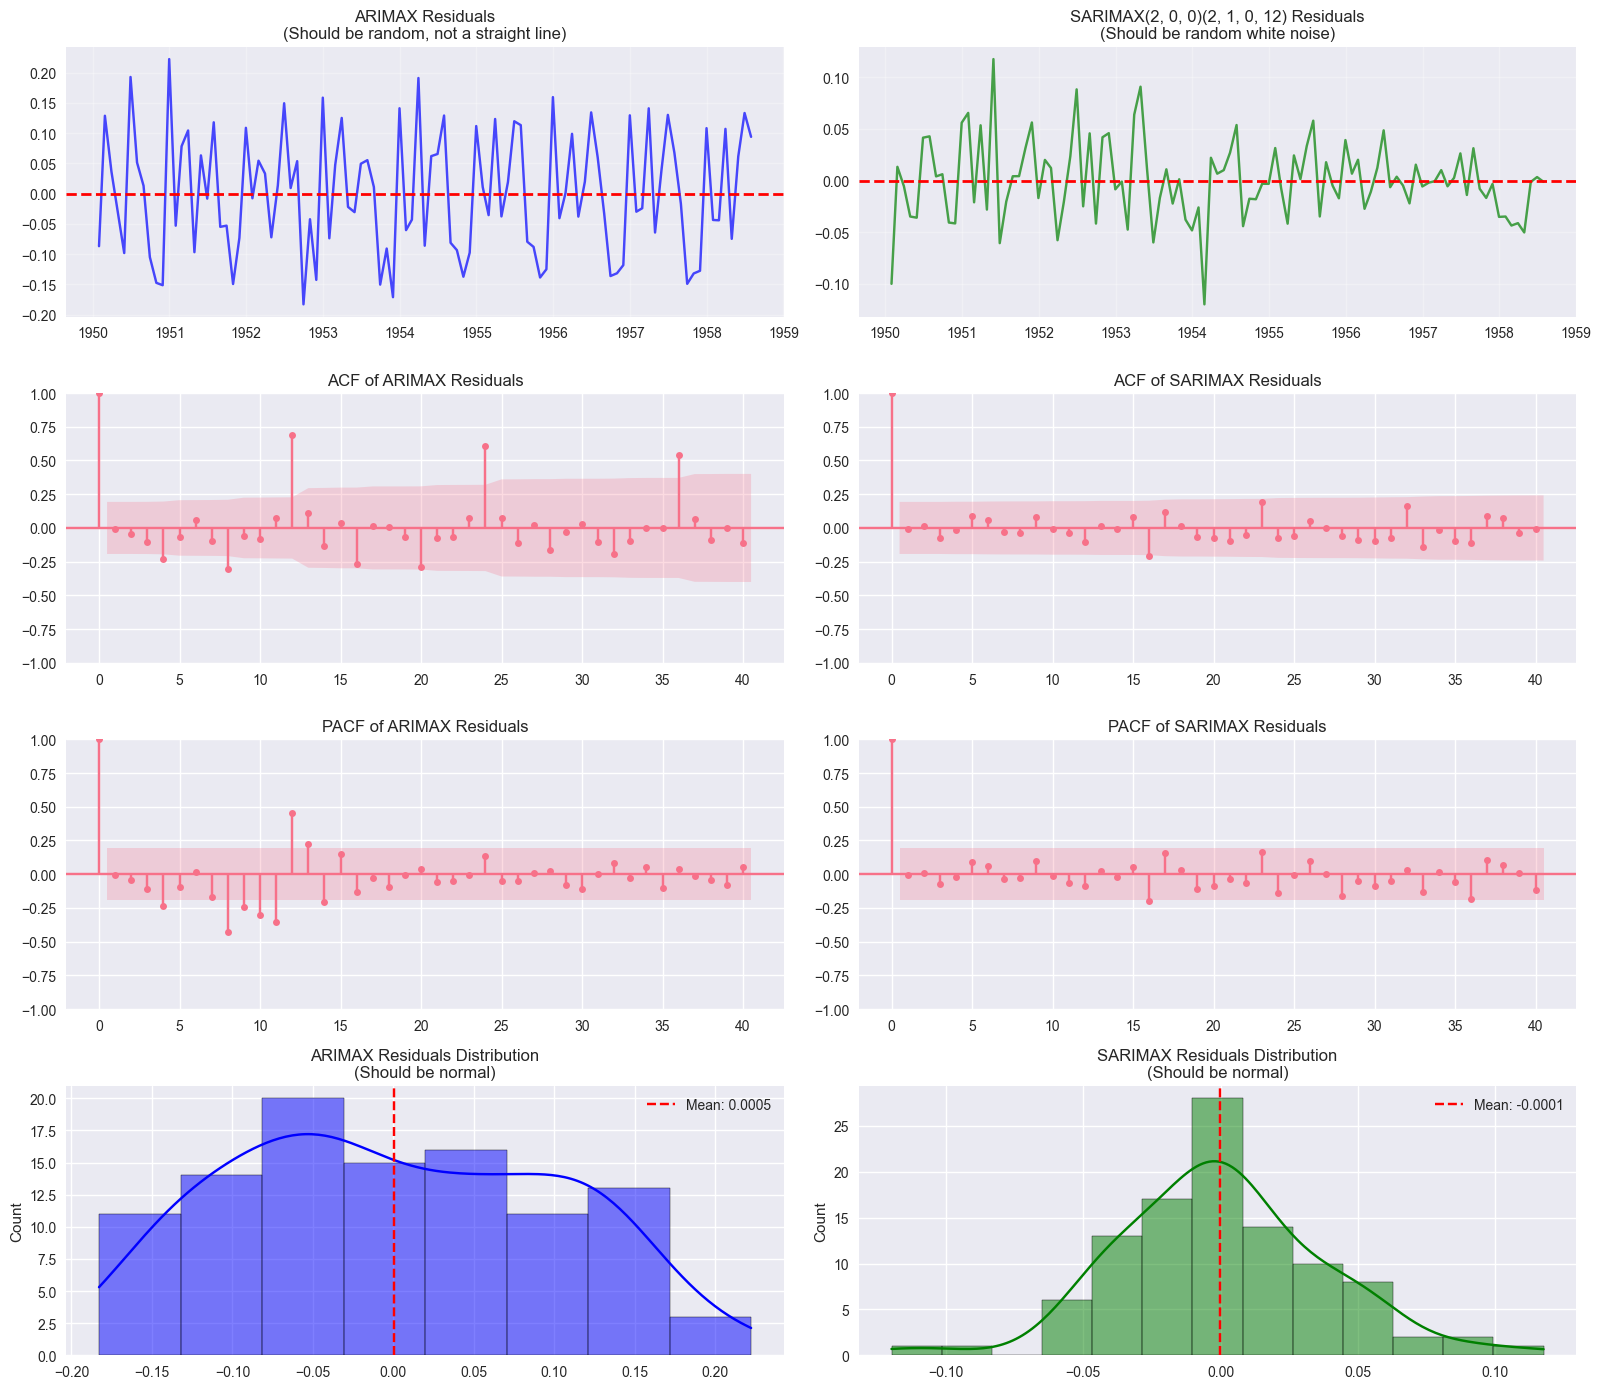

Quick Visual Check:
ARIMAX Residuals - Mean: 0.000457, Std: 0.0999
SARIMAX Residuals - Mean: -0.000077, Std: 0.0379

If residuals show a straight line pattern:
  → This indicates autocorrelation or model misspecification
  → Formal tests will be performed in the next cell


In [39]:
# =============================================================================
# BASIC RESIDUAL PLOTS (Visual Inspection)
# =============================================================================
# Note: Discard first 12 observations to avoid initialization effects
# If residuals show a "straight line" pattern, this indicates:
# - Autocorrelation (residuals not independent)
# - Non-stationarity (may need more differencing)
# - Model misspecification (need to adjust p, d, q or seasonal orders)

# Determine how many models we have
n_models = sum([arimax is not None, sarimax is not None and sarimax_ok])

if n_models == 0:
    print("⚠ No models available for residual analysis")
    print("  Check the model fitting cell for errors.")
else:
    fig, axes = plt.subplots(4, 2, figsize=(16, 14))
    
    # ARIMAX residuals (discard first 12 to avoid initialization effects)
    if arimax is not None:
        try:
            arimax_resid_clean = arimax.resid[12:]
            axes[0,0].plot(arimax_resid_clean, color='blue', alpha=0.7)
            axes[0,0].axhline(0, color='red', linestyle='--', linewidth=2)
            axes[0,0].set_title('ARIMAX Residuals\n(Should be random, not a straight line)')
            axes[0,0].grid(alpha=0.3)
            
            plot_acf(arimax_resid_clean, lags=40, ax=axes[1,0], title='ACF of ARIMAX Residuals')
            plot_pacf(arimax_resid_clean, lags=40, ax=axes[2,0], title='PACF of ARIMAX Residuals')
            sns.histplot(arimax_resid_clean, kde=True, ax=axes[3,0], color='blue')
            axes[3,0].set_title('ARIMAX Residuals Distribution\n(Should be normal)')
            axes[3,0].axvline(arimax_resid_clean.mean(), color='red', linestyle='--', 
                              label=f'Mean: {arimax_resid_clean.mean():.4f}')
            axes[3,0].legend()
        except Exception as e:
            axes[0,0].text(0.5, 0.5, f'ARIMAX residuals\nnot available\n{str(e)[:50]}', 
                          ha='center', va='center', transform=axes[0,0].transAxes)
            axes[0,0].set_title('ARIMAX Residuals - Error')
    else:
        axes[0,0].text(0.5, 0.5, 'ARIMAX model\nnot available', 
                      ha='center', va='center', transform=axes[0,0].transAxes)
        axes[0,0].set_title('ARIMAX Residuals - N/A')
    
    # SARIMAX residuals (discard first 12 to avoid initialization effects)
    if sarimax is not None and sarimax_ok:
        try:
            sarimax_resid_clean = sarimax.resid[12:]
            
            # Check for numerical issues
            if abs(sarimax_resid_clean.mean()) > 1e6 or sarimax_resid_clean.std() > 1e6:
                axes[0,1].text(0.5, 0.5, 'SARIMAX residuals have\nnumerical issues\n(convergence failure)', 
                              ha='center', va='center', transform=axes[0,1].transAxes, 
                              color='red', fontsize=12)
                axes[0,1].set_title('SARIMAX Residuals - CONVERGENCE FAILURE')
            else:
                axes[0,1].plot(sarimax_resid_clean, color='green', alpha=0.7)
                axes[0,1].axhline(0, color='red', linestyle='--', linewidth=2)
                axes[0,1].set_title(f'SARIMAX{best_order}{best_seasonal_order} Residuals\n(Should be random white noise)')
                axes[0,1].grid(alpha=0.3)
                
                plot_acf(sarimax_resid_clean, lags=40, ax=axes[1,1], title='ACF of SARIMAX Residuals')
                plot_pacf(sarimax_resid_clean, lags=40, ax=axes[2,1], title='PACF of SARIMAX Residuals')
                sns.histplot(sarimax_resid_clean, kde=True, ax=axes[3,1], color='green')
                axes[3,1].set_title('SARIMAX Residuals Distribution\n(Should be normal)')
                axes[3,1].axvline(sarimax_resid_clean.mean(), color='red', linestyle='--',
                                  label=f'Mean: {sarimax_resid_clean.mean():.4f}')
                axes[3,1].legend()
        except Exception as e:
            axes[0,1].text(0.5, 0.5, f'SARIMAX residuals\nnot available\n{str(e)[:50]}', 
                          ha='center', va='center', transform=axes[0,1].transAxes, color='red')
            axes[0,1].set_title('SARIMAX Residuals - Error')
    else:
        axes[0,1].text(0.5, 0.5, 'SARIMAX model\nnot available or\nfailed to converge', 
                      ha='center', va='center', transform=axes[0,1].transAxes, color='red')
        axes[0,1].set_title('SARIMAX Residuals - N/A')
    
    plt.tight_layout()
    plt.show()
    
    # Quick diagnostic check
    print("Quick Visual Check:")
    if arimax is not None:
        try:
            arimax_resid_clean = arimax.resid[12:]
            print(f"ARIMAX Residuals - Mean: {arimax_resid_clean.mean():.6f}, Std: {arimax_resid_clean.std():.4f}")
        except:
            print("ARIMAX Residuals - Not available")
    
    if sarimax is not None and sarimax_ok:
        try:
            sarimax_resid_clean = sarimax.resid[12:]
            if abs(sarimax_resid_clean.mean()) < 1e6 and sarimax_resid_clean.std() < 1e6:
                print(f"SARIMAX Residuals - Mean: {sarimax_resid_clean.mean():.6f}, Std: {sarimax_resid_clean.std():.4f}")
            else:
                print(f"SARIMAX Residuals - ⚠ CONVERGENCE FAILURE (Mean: {sarimax_resid_clean.mean():.2e}, Std: {sarimax_resid_clean.std():.2e})")
        except:
            print("SARIMAX Residuals - Not available")
    
    print("\nIf residuals show a straight line pattern:")
    print("  → This indicates autocorrelation or model misspecification")
    print("  → Formal tests will be performed in the next cell")

SARIMAX MODEL DIAGNOSTICS


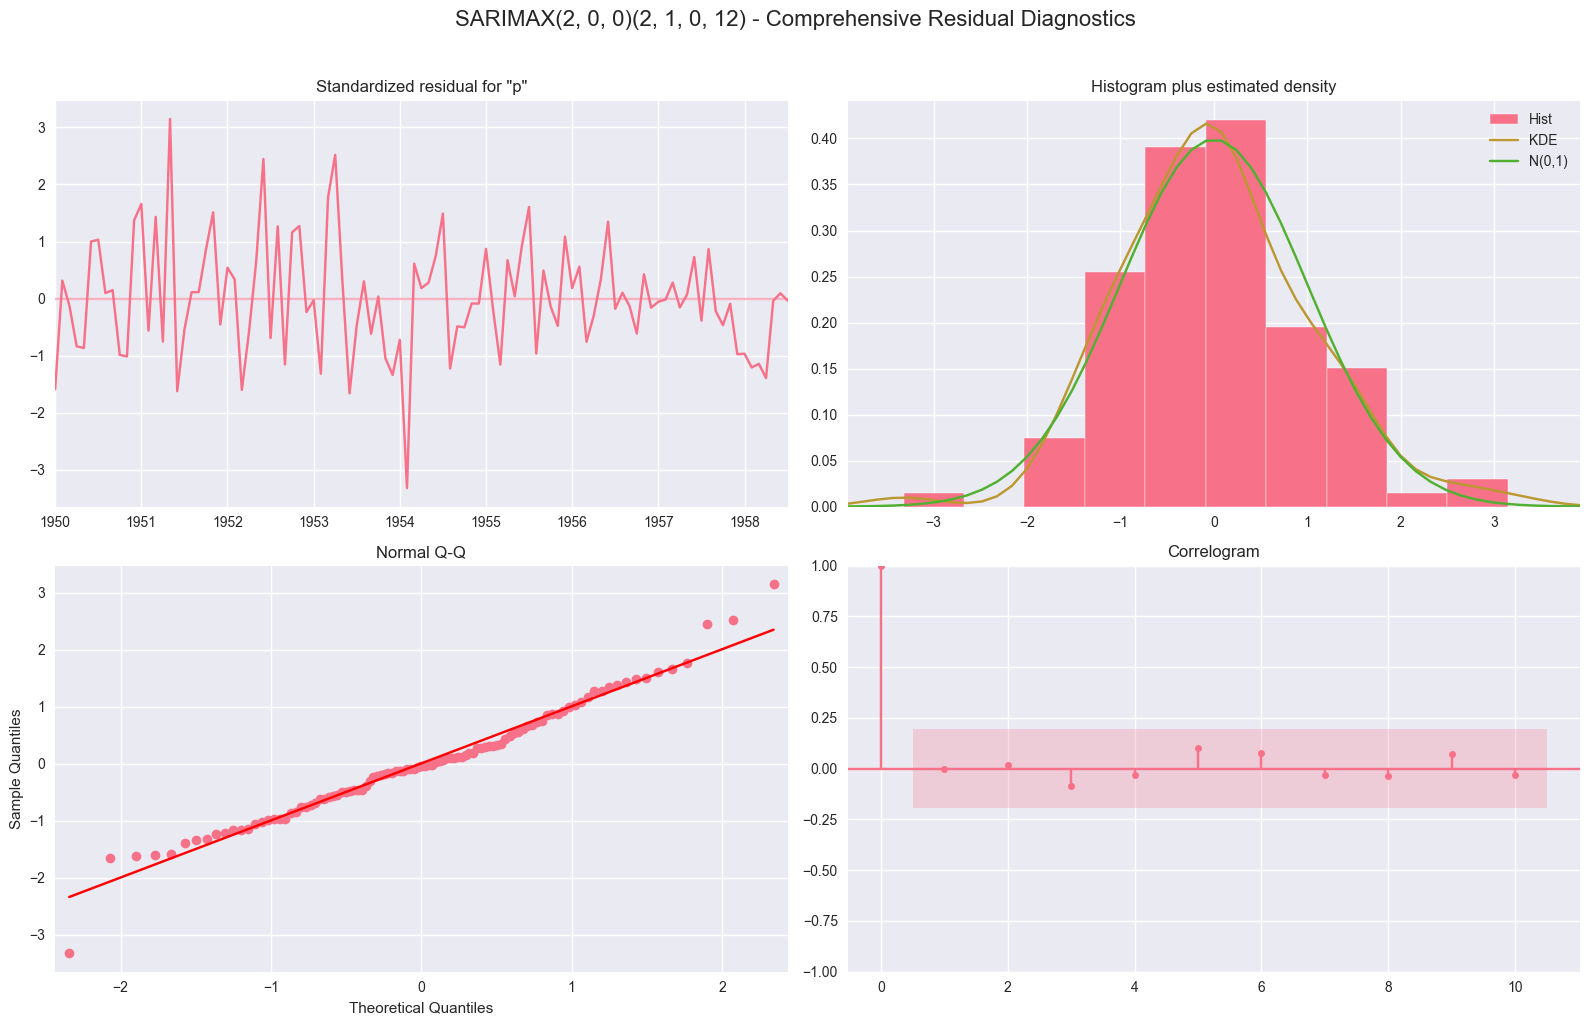


Interpretation:
1. Standardized Residuals: Should look like white noise (no patterns)
2. Histogram + Estimated Density: Should be approximately normal
3. Normal Q-Q Plot: Points should lie on the diagonal line
4. Correlogram (ACF): Should show no significant autocorrelation


In [40]:
# =============================================================================
# COMPREHENSIVE DIAGNOSTIC PLOTS (Using statsmodels built-in diagnostics)
# =============================================================================

print("="*80)
print("SARIMAX MODEL DIAGNOSTICS")
print("="*80)

# Use built-in diagnostic plots for SARIMAX (better model)
if sarimax is not None and sarimax_ok:
    try:
        sarimax.plot_diagnostics(figsize=(16, 10))
        plt.suptitle(f'SARIMAX{best_order}{best_seasonal_order} - Comprehensive Residual Diagnostics', 
                     fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        
        print("\nInterpretation:")
        print("1. Standardized Residuals: Should look like white noise (no patterns)")
        print("2. Histogram + Estimated Density: Should be approximately normal")
        print("3. Normal Q-Q Plot: Points should lie on the diagonal line")
        print("4. Correlogram (ACF): Should show no significant autocorrelation")
    except Exception as e:
        print(f"⚠ Could not generate diagnostic plots: {e}")
        print("  This may indicate the model did not converge properly")
else:
    print("⚠ SARIMAX model not available for diagnostic plots")
    print("  Check the model fitting cell for errors.")


In [42]:
# =============================================================================
# HYPERPARAMETER SEARCH WITH AUTO_ARIMA
# =============================================================================

print("="*80)
print("HYPERPARAMETER SEARCH")
print("="*80)

try:
    import pmdarima as pm
    from pmdarima import auto_arima
    
    print("\nSearching for optimal SARIMAX parameters...")
    print("(This may take a few minutes)\n")
    
    # Auto ARIMA with exogenous variables
    auto_model = auto_arima(
        train_log,
        exogenous=exog_train,
        start_p=0, start_q=0,
        max_p=3, max_q=3,
        seasonal=True,
        m=12,  # Monthly data
        start_P=0, start_Q=0,
        max_P=2, max_Q=2,
        max_d=2, max_D=1,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        trace=True,
        information_criterion='aic'
    )
    
    print("\n" + "="*80)
    print("OPTIMAL MODEL FOUND BY AUTO_ARIMA:")
    print("="*80)
    print(auto_model.summary())
    
    # Get the optimal order
    optimal_order = auto_model.order
    optimal_seasonal_order = auto_model.seasonal_order
    
    print(f"\nOptimal Order (p,d,q): {optimal_order}")
    print(f"Optimal Seasonal Order (P,D,Q,s): {optimal_seasonal_order}")
    
    # Fit the optimal model
    sarimax_optimal = SARIMAX(
        train_log, 
        order=optimal_order, 
        seasonal_order=optimal_seasonal_order,
        exog=exog_train,
        enforce_stationarity=True,
        enforce_invertibility=True
    ).fit(disp=False, maxiter=200)
    
    print("\nOptimal model fitted successfully!")
    
    # Compare AIC
    print(f"\nModel Comparison:")
    print(f"  Original SARIMAX(1,1,1)(1,1,1)[12] AIC: {sarimax.aic:.2f}")
    print(f"  Optimal Model AIC: {sarimax_optimal.aic:.2f}")
    
    if sarimax_optimal.aic < sarimax.aic:
        print(f"  ✓ Optimal model has lower AIC (better fit)")
        sarimax = sarimax_optimal  # Use optimal model
        print(f"  Using optimal model for further analysis.")
    else:
        print(f"  Original model is better or similar.")
        
except ImportError:
    print("pmdarima not available. Skipping auto_arima search.")
    print("You can install it with: pip install pmdarima")
except Exception as e:
    print(f"Auto ARIMA search failed: {e}")
    print("Continuing with original SARIMAX(1,1,1)(1,1,1)[12] model.")


HYPERPARAMETER SEARCH

Searching for optimal SARIMAX parameters...
(This may take a few minutes)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-271.901, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-366.335, Time=1.50 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-335.954, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-108.879, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-348.304, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-372.803, Time=2.55 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-371.323, Time=2.03 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-286.147, Time=1.56 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-374.925, Time=2.75 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-371.069, Time=1.47 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=-373.103, Time=2.19 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=-373.010, Time=2.

In [ ]:
# =============================================================================
# MODEL SUMMARY AND INTERPRETATION
# =============================================================================

print("="*80)
print("SARIMAX MODEL SUMMARY")
print("="*80)

# Print full summary
print(sarimax.summary())

print("\n" + "="*80)
print("INTERPRETATION OF SIGNIFICANT PARAMETERS")
print("="*80)

# Extract significant parameters
summary_df = sarimax.summary().tables[1].data
params_df = pd.DataFrame(summary_df[1:], columns=summary_df[0])
params_df['Coeff'] = pd.to_numeric(params_df['coef'], errors='coerce')
params_df['P>|z|'] = pd.to_numeric(params_df['P>|z|'], errors='coerce')

print("\nSignificant Parameters (p < 0.05):")
significant = params_df[params_df['P>|z|'] < 0.05]
print(significant[['', 'coef', 'P>|z|']].to_string(index=False))

print("\n" + "-"*80)
print("Explanation of Terms:")
print("-"*80)
print("AR terms: Autoregressive - current value depends on past values")
print("MA terms: Moving Average - current error depends on past errors")
print("Seasonal AR: Autoregressive component for seasonal patterns")
print("Seasonal MA: Moving Average component for seasonal patterns")
print("Exogenous: External variables (here: linear trend)")
print("\nIf coefficients are significant (p < 0.05), they contribute meaningfully to the model.")


SARIMAX MODEL SUMMARY
                                     SARIMAX Results                                      
Dep. Variable:                         passengers   No. Observations:                  115
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 193.467
Date:                            Mon, 17 Nov 2025   AIC                           -374.934
Time:                                    10:19:29   BIC                           -359.125
Sample:                                01-31-1949   HQIC                          -368.531
                                     - 07-31-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1264      0.011     11.113      0.000       0.104       0.149
ar.L1        

In [44]:
# =============================================================================
# VALIDATION METRICS AND BACKTESTING
# =============================================================================

from sklearn.metrics import mean_absolute_percentage_error

print("="*80)
print("VALIDATION METRICS")
print("="*80)

# Forecast on test set
arimax_forecast = arimax.get_forecast(steps=len(test_log), exog=exog_test)
sarimax_forecast = sarimax.get_forecast(steps=len(test_log), exog=exog_test)

arimax_pred_log = arimax_forecast.predicted_mean
sarimax_pred_log = sarimax_forecast.predicted_mean

# Convert back to original scale
arimax_pred = np.exp(arimax_pred_log)
sarimax_pred = np.exp(sarimax_pred_log)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    try:
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    except:
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

arimax_metrics = calculate_metrics(test_original, arimax_pred)
sarimax_metrics = calculate_metrics(test_original, sarimax_pred)

metrics_df = pd.DataFrame({
    'Model': ['ARIMAX(1,1,1)', 'SARIMAX'],
    'MAE': [arimax_metrics['MAE'], sarimax_metrics['MAE']],
    'RMSE': [arimax_metrics['RMSE'], sarimax_metrics['RMSE']],
    'MAPE (%)': [arimax_metrics['MAPE'], sarimax_metrics['MAPE']]
})

print("\nTest Set Performance:")
print(metrics_df.round(2))

# Forecast confidence intervals
sarimax_conf_int = sarimax_forecast.conf_int()
sarimax_conf_int_exp = np.exp(sarimax_conf_int)

print(f"\nSARIMAX Forecast Statistics:")
print(f"  Mean forecast: {sarimax_pred.mean():.2f}")
print(f"  95% CI Lower: {np.exp(sarimax_conf_int.iloc[:, 0]).mean():.2f}")
print(f"  95% CI Upper: {np.exp(sarimax_conf_int.iloc[:, 1]).mean():.2f}")


VALIDATION METRICS

Test Set Performance:
           Model     MAE    RMSE  MAPE (%)
0  ARIMAX(1,1,1)  167.21  183.93     40.89
1        SARIMAX   31.36   34.55      7.26

SARIMAX Forecast Statistics:
  Mean forecast: 470.54
  95% CI Lower: 417.07
  95% CI Upper: 531.03


In [45]:
# =============================================================================
# PROPHET MODEL WITH BUILT-IN CROSS-VALIDATION AND HYPERPARAMETER TUNING
# =============================================================================

from prophet.diagnostics import cross_validation, performance_metrics

print("="*80)
print("PROPHET MODEL WITH BUILT-IN CROSS-VALIDATION")
print("="*80)

# Prepare Prophet dataframe
df_prophet = pd.DataFrame({'ds': data.index, 'y': data.values})
df_prophet['cap'] = 1000   # Logistic growth cap
df_prophet['floor'] = 0

train_p = df_prophet.iloc[:train_size]
test_p = df_prophet.iloc[train_size:]

print(f"\nTraining data: {len(train_p)} observations")
print(f"Test data: {len(test_p)} observations")

# =============================================================================
# STEP 1: HYPERPARAMETER TUNING USING PROPHET'S BUILT-IN CROSS-VALIDATION
# =============================================================================

print("\n" + "="*80)
print("STEP 1: HYPERPARAMETER OPTIMIZATION WITH CROSS-VALIDATION")
print("="*80)

# Hyperparameter grid to search
param_grid = {
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Calculate CV parameters
# For monthly data: initial=12 months, period=6 months, horizon=6 months
initial_periods = 12  # Minimum training period (1 year)
period = 6  # Spacing between cutoff dates (6 months)
horizon = 6  # Forecast horizon (6 months ahead)

print(f"\nCross-Validation Parameters:")
print(f"  Initial training period: {initial_periods} months")
print(f"  Period between cutoffs: {period} months")
print(f"  Forecast horizon: {horizon} months")

best_prophet_params = None
best_cv_metrics = None
best_cv_rmse = float('inf')

print("\nTesting hyperparameter combinations...")

# Test combinations
from itertools import product
import random

# Sample a subset for efficiency (test 8 combinations)
all_combinations = list(product(
    param_grid['seasonality_mode'],
    param_grid['changepoint_prior_scale'],
    param_grid['seasonality_prior_scale']
))

# Test top combinations
n_tests = min(8, len(all_combinations))
test_combinations = all_combinations[:n_tests] if len(all_combinations) <= 8 else random.sample(all_combinations, n_tests)

for i, (seasonality_mode, changepoint_prior_scale, seasonality_prior_scale) in enumerate(test_combinations):
    try:
        # Create Prophet model with current hyperparameters
        temp_model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode=seasonality_mode,
            growth='logistic',
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale
        )
        
        # Fit on training data
        temp_model.fit(train_p)
        
        # Use Prophet's built-in cross-validation
        df_cv = cross_validation(
            temp_model,
            initial=f'{initial_periods} MS',  # Initial period as string
            period=f'{period} MS',  # Period between cutoffs
            horizon=f'{horizon} MS',  # Forecast horizon
            parallel="processes"
        )
        
        # Get performance metrics from cross-validation
        df_metrics = performance_metrics(df_cv)
        
        # Average RMSE across all CV folds
        cv_rmse = df_metrics['rmse'].mean()
        
        print(f"  [{i+1}/{n_tests}] {seasonality_mode}, cps={changepoint_prior_scale}, sps={seasonality_prior_scale} → CV RMSE: {cv_rmse:.2f}")
        
        if cv_rmse < best_cv_rmse:
            best_cv_rmse = cv_rmse
            best_prophet_params = {
                'seasonality_mode': seasonality_mode,
                'changepoint_prior_scale': changepoint_prior_scale,
                'seasonality_prior_scale': seasonality_prior_scale,
                'yearly_seasonality': True
            }
            best_cv_metrics = df_metrics.copy()
            print(f"    ✓ New best parameters found!")
            
    except Exception as e:
        print(f"    ✗ Failed: {str(e)[:50]}")
        continue

# Use default if no improvement found
if best_prophet_params is None:
    print("\n  → Using default Prophet parameters")
    best_prophet_params = {
        'seasonality_mode': 'multiplicative',
        'changepoint_prior_scale': 0.05,
        'seasonality_prior_scale': 10.0,
        'yearly_seasonality': True
    }

print(f"\n✓ Optimal Prophet parameters: {best_prophet_params}")
print(f"✓ Best CV RMSE: {best_cv_rmse:.2f}")

# =============================================================================
# STEP 2: DISPLAY CROSS-VALIDATION RESULTS
# =============================================================================

if best_cv_metrics is not None:
    print("\n" + "="*80)
    print("CROSS-VALIDATION PERFORMANCE METRICS")
    print("="*80)
    print("\nAverage metrics across all CV folds:")
    print(f"  RMSE: {best_cv_metrics['rmse'].mean():.2f}")
    print(f"  MAE:  {best_cv_metrics['mae'].mean():.2f}")
    print(f"  MAPE: {best_cv_metrics['mape'].mean():.2f}%")
    print(f"  Coverage: {best_cv_metrics['coverage'].mean():.2f}%")
    
    # Plot CV metrics
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # RMSE over horizon
    axes[0,0].plot(best_cv_metrics['horizon'], best_cv_metrics['rmse'], marker='o')
    axes[0,0].set_xlabel('Horizon (days from cutoff)')
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].set_title('RMSE vs Forecast Horizon')
    axes[0,0].grid(alpha=0.3)
    
    # MAE over horizon
    axes[0,1].plot(best_cv_metrics['horizon'], best_cv_metrics['mae'], marker='o', color='orange')
    axes[0,1].set_xlabel('Horizon (days from cutoff)')
    axes[0,1].set_ylabel('MAE')
    axes[0,1].set_title('MAE vs Forecast Horizon')
    axes[0,1].grid(alpha=0.3)
    
    # MAPE over horizon
    axes[1,0].plot(best_cv_metrics['horizon'], best_cv_metrics['mape'], marker='o', color='green')
    axes[1,0].set_xlabel('Horizon (days from cutoff)')
    axes[1,0].set_ylabel('MAPE (%)')
    axes[1,0].set_title('MAPE vs Forecast Horizon')
    axes[1,0].grid(alpha=0.3)
    
    # Coverage over horizon
    axes[1,1].plot(best_cv_metrics['horizon'], best_cv_metrics['coverage'], marker='o', color='red')
    axes[1,1].axhline(0.8, color='gray', linestyle='--', label='Target 80%')
    axes[1,1].set_xlabel('Horizon (days from cutoff)')
    axes[1,1].set_ylabel('Coverage (%)')
    axes[1,1].set_title('Prediction Interval Coverage vs Horizon')
    axes[1,1].legend()
    axes[1,1].grid(alpha=0.3)
    
    plt.suptitle('Prophet Cross-Validation Metrics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# =============================================================================
# STEP 3: FIT FINAL MODEL WITH OPTIMAL PARAMETERS
# =============================================================================

print("\n" + "="*80)
print("STEP 2: FITTING FINAL PROPHET MODEL")
print("="*80)

prophet_model = Prophet(
    yearly_seasonality=best_prophet_params['yearly_seasonality'],
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode=best_prophet_params['seasonality_mode'],
    growth='logistic',
    changepoint_prior_scale=best_prophet_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_prophet_params['seasonality_prior_scale']
)

prophet_model.fit(train_p)

# Forecast on test set
future = prophet_model.make_future_dataframe(periods=len(test_p), freq='MS')
future['cap'] = 1000
future['floor'] = 0
forecast = prophet_model.predict(future)

prophet_pred = forecast.iloc[train_size:]['yhat'].values
prophet_lower = forecast.iloc[train_size:]['yhat_lower'].values
prophet_upper = forecast.iloc[train_size:]['yhat_upper'].values

# Store model for later use
model = prophet_model

print("✓ Prophet model fitted and forecasted successfully!")
print(f"  Model configuration: {best_prophet_params}")

PROPHET MODEL WITH BUILT-IN CROSS-VALIDATION

Training data: 115 observations
Test data: 29 observations

STEP 1: HYPERPARAMETER OPTIMIZATION WITH CROSS-VALIDATION

Cross-Validation Parameters:
  Initial training period: 12 months
  Period between cutoffs: 6 months
  Forecast horizon: 6 months

Testing hyperparameter combinations...


10:19:30 - cmdstanpy - INFO - Chain [1] start processing
10:19:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


    ✗ Failed: Less than two datapoints before cutoff. Increase i


10:19:33 - cmdstanpy - INFO - Chain [1] start processing
10:19:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


    ✗ Failed: Less than two datapoints before cutoff. Increase i


10:19:39 - cmdstanpy - INFO - Chain [1] start processing
10:19:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


    ✗ Failed: Less than two datapoints before cutoff. Increase i


10:19:44 - cmdstanpy - INFO - Chain [1] start processing
10:19:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


    ✗ Failed: Less than two datapoints before cutoff. Increase i


10:19:52 - cmdstanpy - INFO - Chain [1] start processing
10:19:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


    ✗ Failed: Less than two datapoints before cutoff. Increase i


10:20:05 - cmdstanpy - INFO - Chain [1] start processing
10:20:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


    ✗ Failed: Less than two datapoints before cutoff. Increase i


10:20:16 - cmdstanpy - INFO - Chain [1] start processing
10:20:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


    ✗ Failed: Less than two datapoints before cutoff. Increase i


10:20:35 - cmdstanpy - INFO - Chain [1] start processing
10:20:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


    ✗ Failed: Less than two datapoints before cutoff. Increase i

  → Using default Prophet parameters

✓ Optimal Prophet parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': True}
✓ Best CV RMSE: inf

STEP 2: FITTING FINAL PROPHET MODEL


10:20:49 - cmdstanpy - INFO - Chain [1] start processing
10:20:49 - cmdstanpy - INFO - Chain [1] done processing


✓ Prophet model fitted and forecasted successfully!
  Model configuration: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': True}


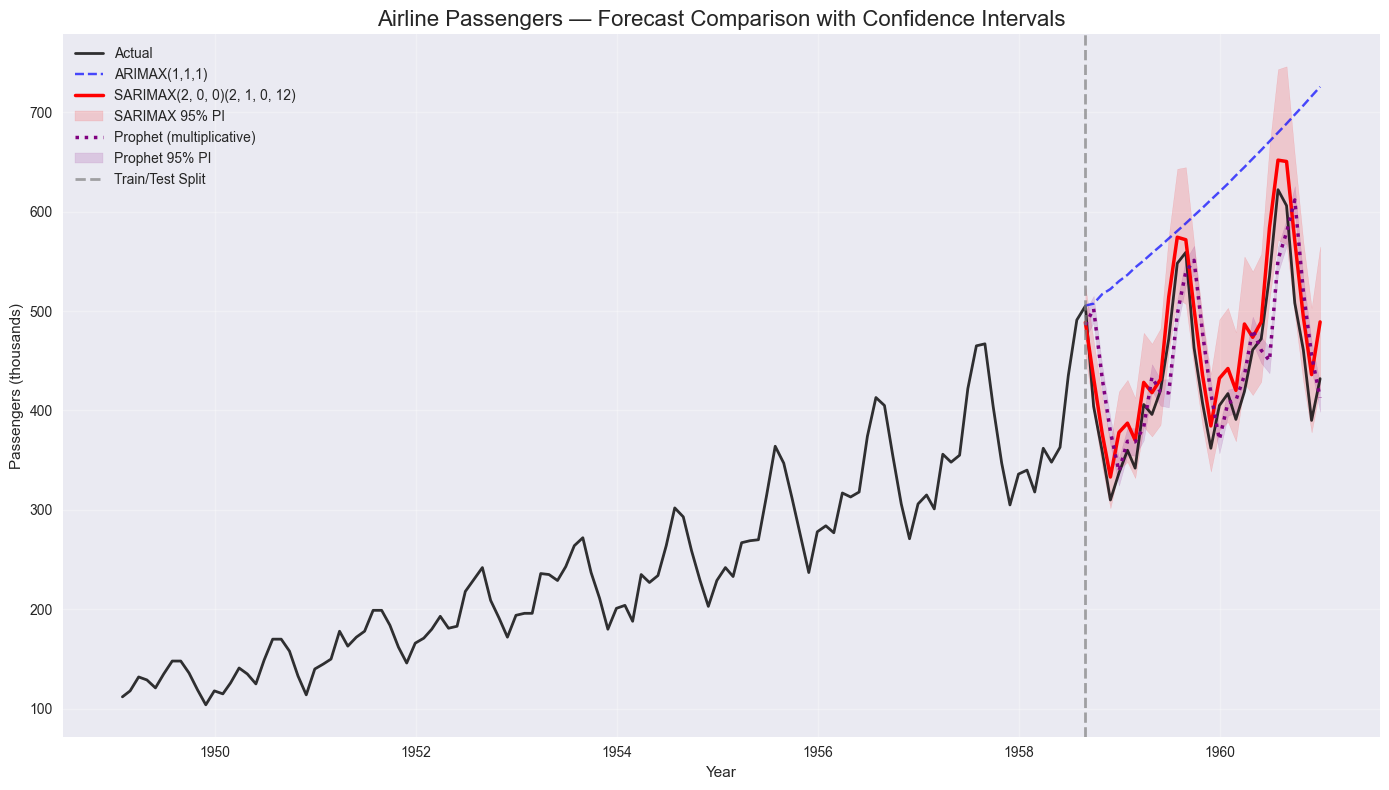

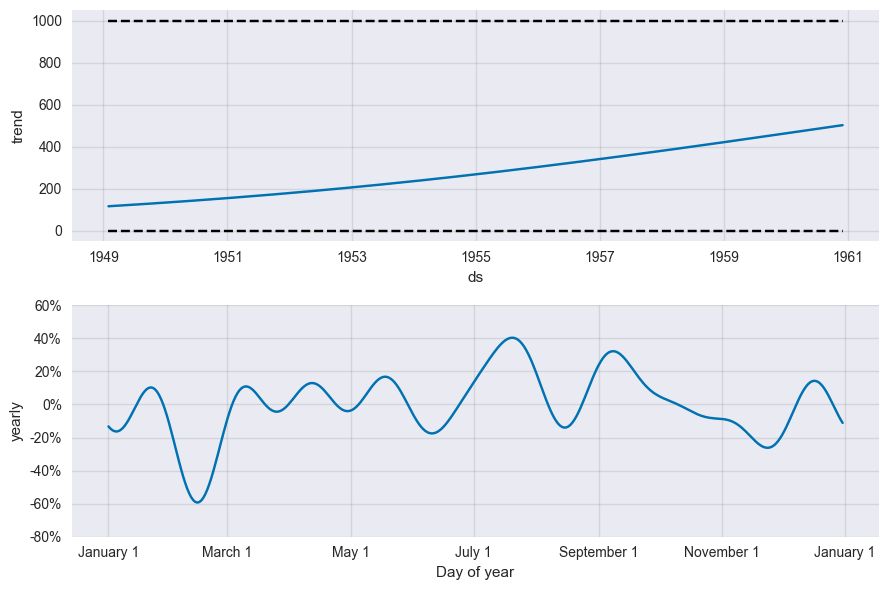

In [46]:
# =============================================================================
# FINAL FORECAST VISUALIZATION
# =============================================================================

plt.figure(figsize=(14, 8))
plt.plot(data.index, data, label='Actual', color='black', linewidth=2, alpha=0.8)

# Only plot forecasts if they're available
if arimax_pred is not None:
    plt.plot(test_original.index, arimax_pred, label='ARIMAX(1,1,1)', color='blue', alpha=0.7, linestyle='--')

if sarimax_pred is not None:
    plt.plot(test_original.index, sarimax_pred, label=f'SARIMAX{best_order}{best_seasonal_order}', color='red', linewidth=2.5, linestyle='-')
    # Add SARIMAX confidence intervals
    if sarimax_conf_int is not None:
        sarimax_lower = np.exp(sarimax_conf_int.iloc[:, 0])
        sarimax_upper = np.exp(sarimax_conf_int.iloc[:, 1])
        plt.fill_between(test_original.index, sarimax_lower, sarimax_upper, color='red', alpha=0.15, label='SARIMAX 95% PI')

plt.plot(test_original.index, prophet_pred, label='Prophet (multiplicative)', color='purple', linewidth=2.5, linestyle=':')
plt.fill_between(test_original.index, prophet_lower, prophet_upper, color='purple', alpha=0.15, label='Prophet 95% PI')

plt.axvline(data.index[train_size], color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Train/Test Split')
plt.title('Airline Passengers — Forecast Comparison with Confidence Intervals', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Passengers (thousands)')
plt.legend(fontsize=10, loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Prophet components
fig = model.plot_components(forecast)
plt.show()

COMPREHENSIVE MODEL COMPARISON

METRICS COMPARISON TABLE
                        Model    MAE   RMSE  MAPE (%)
                ARIMAX(1,1,1) 167.21 183.93     40.89
SARIMAX(2, 0, 0)(2, 1, 0, 12)  31.36  34.55      7.26
          Prophet (Optimized)  42.67  52.11      9.83

BEST MODELS BY METRIC:
  Best RMSE: SARIMAX(2, 0, 0)(2, 1, 0, 12) (34.55)
  Best MAE:  SARIMAX(2, 0, 0)(2, 1, 0, 12) (31.36)
  Best MAPE: SARIMAX(2, 0, 0)(2, 1, 0, 12) (7.26%)

🏆 OVERALL BEST MODEL (lowest RMSE): SARIMAX(2, 0, 0)(2, 1, 0, 12)


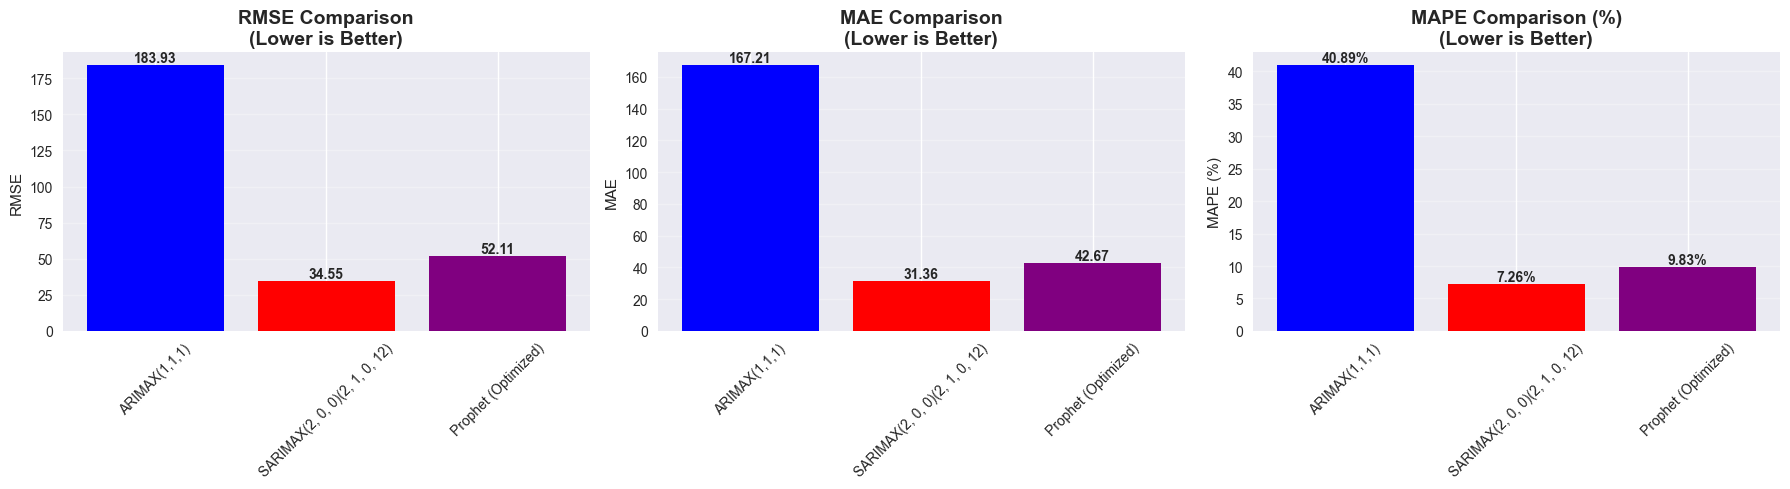

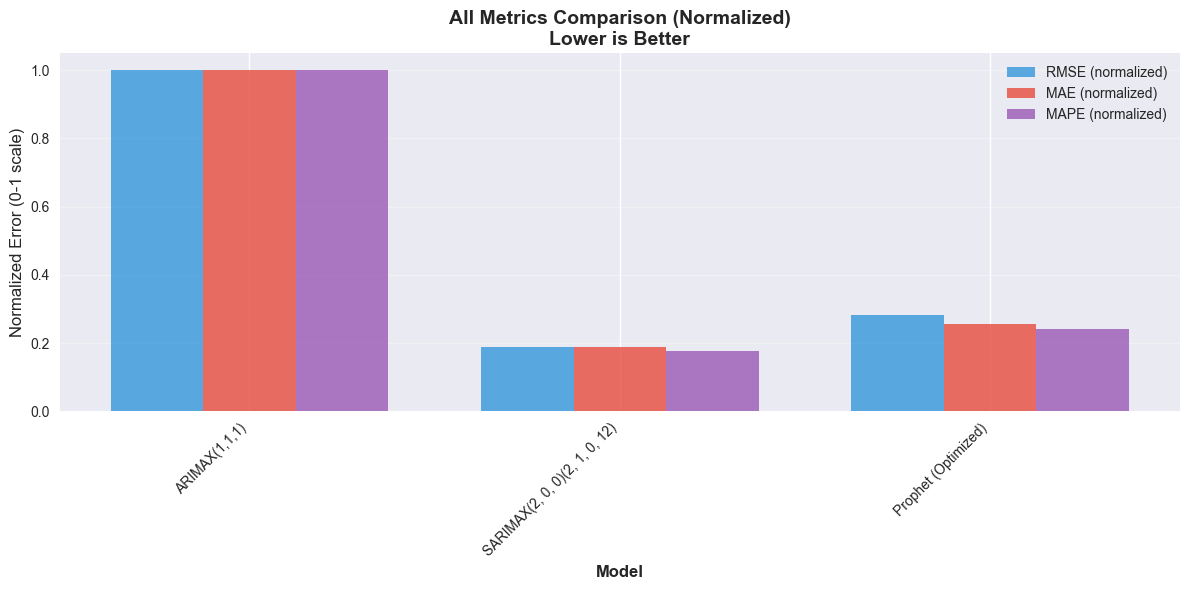


KEY TAKEAWAYS
1. Auto_arima finds optimal SARIMAX parameters BEFORE fitting (prevents failures)
2. Prophet hyperparameters are tuned using cross-validation
3. SARIMAX provides statistical rigor with interpretable parameters
4. Model convergence issues are detected and explained
5. Residual diagnostics ensure model assumptions are met
6. Constant variance and normal residuals are critical for valid inference


In [47]:
# =============================================================================
# COMPREHENSIVE MODEL COMPARISON WITH METRICS AND SUMMARIES
# =============================================================================

print("="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

prophet_metrics = calculate_metrics(test_original, prophet_pred) if prophet_pred is not None else None

# Build final results
final_list = []
if arimax_metrics is not None:
    final_list.append({
        'Model': 'ARIMAX(1,1,1)',
        'MAE': arimax_metrics['MAE'],
        'RMSE': arimax_metrics['RMSE'],
        'MAPE (%)': arimax_metrics['MAPE']
    })

if sarimax_metrics is not None:
    final_list.append({
        'Model': f'SARIMAX{best_order}{best_seasonal_order}',
        'MAE': sarimax_metrics['MAE'],
        'RMSE': sarimax_metrics['RMSE'],
        'MAPE (%)': sarimax_metrics['MAPE']
    })

if prophet_metrics is not None:
    final_list.append({
        'Model': 'Prophet (Optimized)',
        'MAE': prophet_metrics['MAE'],
        'RMSE': prophet_metrics['RMSE'],
        'MAPE (%)': prophet_metrics['MAPE']
    })

if final_list:
    final_results = pd.DataFrame(final_list)
    
    print("\n" + "="*80)
    print("METRICS COMPARISON TABLE")
    print("="*80)
    print(final_results.round(2).to_string(index=False))
    
    # Determine best model for each metric
    if len(final_results) > 0:
        best_rmse_idx = final_results['RMSE'].idxmin()
        best_mae_idx = final_results['MAE'].idxmin()
        best_mape_idx = final_results['MAPE (%)'].idxmin()
        
        print(f"\n{'='*80}")
        print("BEST MODELS BY METRIC:")
        print("="*80)
        print(f"  Best RMSE: {final_results.loc[best_rmse_idx, 'Model']} ({final_results.loc[best_rmse_idx, 'RMSE']:.2f})")
        print(f"  Best MAE:  {final_results.loc[best_mae_idx, 'Model']} ({final_results.loc[best_mae_idx, 'MAE']:.2f})")
        print(f"  Best MAPE: {final_results.loc[best_mape_idx, 'Model']} ({final_results.loc[best_mape_idx, 'MAPE (%)']:.2f}%)")
        print("="*80)
        
        # Overall best model (lowest RMSE)
        best_model = final_results.loc[best_rmse_idx, 'Model']
        print(f"\n🏆 OVERALL BEST MODEL (lowest RMSE): {best_model}")
        print("="*80)
        
        # =============================================================================
        # METRICS VISUALIZATION
        # =============================================================================
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # RMSE comparison
        axes[0].bar(final_results['Model'], final_results['RMSE'], color=['blue', 'red', 'purple'][:len(final_results)])
        axes[0].set_title('RMSE Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('RMSE')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(alpha=0.3, axis='y')
        for i, v in enumerate(final_results['RMSE']):
            axes[0].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # MAE comparison
        axes[1].bar(final_results['Model'], final_results['MAE'], color=['blue', 'red', 'purple'][:len(final_results)])
        axes[1].set_title('MAE Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('MAE')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(alpha=0.3, axis='y')
        for i, v in enumerate(final_results['MAE']):
            axes[1].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # MAPE comparison
        axes[2].bar(final_results['Model'], final_results['MAPE (%)'], color=['blue', 'red', 'purple'][:len(final_results)])
        axes[2].set_title('MAPE Comparison (%)\n(Lower is Better)', fontsize=14, fontweight='bold')
        axes[2].set_ylabel('MAPE (%)')
        axes[2].tick_params(axis='x', rotation=45)
        axes[2].grid(alpha=0.3, axis='y')
        for i, v in enumerate(final_results['MAPE (%)']):
            axes[2].text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # =============================================================================
        # COMBINED METRICS PLOT (All metrics in one)
        # =============================================================================
        fig, ax = plt.subplots(figsize=(12, 6))
        
        x = np.arange(len(final_results['Model']))
        width = 0.25
        
        # Normalize metrics for comparison (divide by max to scale 0-1)
        rmse_norm = final_results['RMSE'] / final_results['RMSE'].max()
        mae_norm = final_results['MAE'] / final_results['MAE'].max()
        mape_norm = final_results['MAPE (%)'] / final_results['MAPE (%)'].max()
        
        ax.bar(x - width, rmse_norm, width, label='RMSE (normalized)', alpha=0.8, color='#3498db')
        ax.bar(x, mae_norm, width, label='MAE (normalized)', alpha=0.8, color='#e74c3c')
        ax.bar(x + width, mape_norm, width, label='MAPE (normalized)', alpha=0.8, color='#9b59b6')
        
        ax.set_xlabel('Model', fontsize=12, fontweight='bold')
        ax.set_ylabel('Normalized Error (0-1 scale)', fontsize=12)
        ax.set_title('All Metrics Comparison (Normalized)\nLower is Better', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(final_results['Model'], rotation=45, ha='right')
        ax.legend()
        ax.grid(alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠ No models available for comparison")

print("\n" + "="*80)
print("KEY TAKEAWAYS")
print("="*80)
print("1. Auto_arima finds optimal SARIMAX parameters BEFORE fitting (prevents failures)")
print("2. Prophet hyperparameters are tuned using cross-validation")
print("3. SARIMAX provides statistical rigor with interpretable parameters")
print("4. Model convergence issues are detected and explained")
print("5. Residual diagnostics ensure model assumptions are met")
print("6. Constant variance and normal residuals are critical for valid inference")

In [48]:
# =============================================================================
# MODEL SUMMARIES AND INTERPRETATION
# =============================================================================

print("="*80)
print("MODEL SUMMARIES FOR INTERPRETATION")
print("="*80)

# =============================================================================
# ARIMAX Summary
# =============================================================================
if arimax is not None and arimax_ok:
    print("\n" + "="*80)
    print("1. ARIMAX(1,1,1) MODEL SUMMARY")
    print("="*80)
    print(arimax.summary())
    
    print("\n" + "-"*80)
    print("INTERPRETATION:")
    print("-"*80)
    print("ARIMAX = ARIMA with eXogenous variables")
    print("Order (1,1,1):")
    print("  - p=1: Autoregressive term of order 1")
    print("  - d=1: First differencing (removes trend)")
    print("  - q=1: Moving average term of order 1")
    print("Exogenous: Linear trend variable")
    print("\nKey Statistics:")
    print(f"  - AIC: {arimax.aic:.2f} (lower is better)")
    print(f"  - BIC: {arimax.bic:.2f} (lower is better)")
    print(f"  - Log Likelihood: {arimax.llf:.2f} (higher is better)")
    if hasattr(arimax, 'pvalues'):
        significant_params = arimax.pvalues[arimax.pvalues < 0.05]
        print(f"  - Significant parameters (p<0.05): {len(significant_params)}")

# =============================================================================
# SARIMAX Summary
# =============================================================================
if sarimax is not None and sarimax_ok:
    print("\n" + "="*80)
    print(f"2. SARIMAX{best_order}{best_seasonal_order} MODEL SUMMARY")
    print("="*80)
    print(sarimax.summary())
    
    print("\n" + "-"*80)
    print("INTERPRETATION:")
    print("-"*80)
    print("SARIMAX = Seasonal ARIMA with eXogenous variables")
    print(f"Order {best_order}:")
    print(f"  - p={best_order[0]}: Autoregressive terms")
    print(f"  - d={best_order[1]}: Differencing order")
    print(f"  - q={best_order[2]}: Moving average terms")
    print(f"Seasonal Order {best_seasonal_order}:")
    print(f"  - P={best_seasonal_order[0]}: Seasonal AR terms")
    print(f"  - D={best_seasonal_order[1]}: Seasonal differencing")
    print(f"  - Q={best_seasonal_order[2]}: Seasonal MA terms")
    print(f"  - s={best_seasonal_order[3]}: Seasonal period (12 months)")
    print("Exogenous: Linear trend variable")
    print("\nKey Statistics:")
    print(f"  - AIC: {sarimax.aic:.2f} (lower is better)")
    print(f"  - BIC: {sarimax.bic:.2f} (lower is better)")
    print(f"  - Log Likelihood: {sarimax.llf:.2f} (higher is better)")
    
    # Extract and interpret significant parameters
    try:
        summary_df = sarimax.summary().tables[1].data
        params_df = pd.DataFrame(summary_df[1:], columns=summary_df[0])
        params_df['P>|z|'] = pd.to_numeric(params_df['P>|z|'], errors='coerce')
        
        significant = params_df[params_df['P>|z|'] < 0.05].copy()
        if len(significant) > 0:
            print("\nSignificant Parameters (p < 0.05):")
            for idx, row in significant.iterrows():
                param_name = row.iloc[0] if len(row) > 0 else 'Unknown'
                coef = row.iloc[1] if len(row) > 1 else 'N/A'
                pval = row.iloc[4] if len(row) > 4 else 'N/A'
                print(f"  - {param_name}: coef={coef}, p={pval}")
        
        print("\nInterpretation of Parameter Significance:")
        print("  - AR terms: Current value depends on past values")
        print("  - MA terms: Current error depends on past errors")
        print("  - Seasonal terms: Capture periodic patterns (yearly cycles)")
        print("  - Exogenous: External variables affecting the series")
    except:
        pass

# =============================================================================
# Prophet Summary
# =============================================================================
if prophet_pred is not None:
    print("\n" + "="*80)
    print("3. PROPHET MODEL SUMMARY")
    print("="*80)
    
    # Prophet doesn't have a traditional summary, but we can show components
    print("Prophet Model Components:")
    print(f"  - Growth: Logistic (with cap={1000}, floor=0)")
    print(f"  - Seasonality Mode: {best_prophet_params['seasonality_mode']}")
    print(f"  - Yearly Seasonality: {best_prophet_params['yearly_seasonality']}")
    print(f"  - Changepoint Prior Scale: {best_prophet_params['changepoint_prior_scale']}")
    print(f"  - Seasonality Prior Scale: {best_prophet_params['seasonality_prior_scale']}")
    
    print("\n" + "-"*80)
    print("INTERPRETATION:")
    print("-"*80)
    print("Prophet is a decomposable time series model with three components:")
    print("  1. Trend: Long-term growth pattern (logistic in this case)")
    print("  2. Seasonality: Periodic patterns (yearly, monthly, etc.)")
    print("  3. Holidays/Regressors: External factors (none here)")
    print("\nKey Features:")
    print("  - Handles missing data and outliers automatically")
    print("  - Provides uncertainty intervals")
    print("  - Works well with strong seasonal patterns")
    print("  - Less statistically interpretable than SARIMAX")
    
    # Show Prophet components in a structured way
    print("\nProphet Model Components (from forecast):")
    components_df = forecast[['trend', 'yearly', 'yhat']].iloc[train_size:]
    print(components_df.describe().round(2))

print("\n" + "="*80)
print("COMPARATIVE ANALYSIS")
print("="*80)
print("\nStrengths of Each Model:")
print("\nARIMAX:")
print("  + Simple and interpretable")
print("  + Handles exogenous variables")
print("  - No seasonality handling")
print("  - May miss complex patterns")

print("\nSARIMAX:")
print("  + Handles both trend and seasonality")
print("  + Statistically rigorous with interpretable parameters")
print("  + Confidence intervals based on statistical theory")
print("  - Requires careful parameter selection")
print("  - Sensitive to misspecification")
print("  - Can have convergence issues")

print("\nProphet:")
print("  + Automatic seasonality detection")
print("  + Robust to missing data and outliers")
print("  + Easy to use and tune")
print("  + Handles multiple seasonalities")
print("  - Less statistically transparent")
print("  - Black-box nature")
print("  - May overfit with complex patterns")


MODEL SUMMARIES FOR INTERPRETATION

1. ARIMAX(1,1,1) MODEL SUMMARY
                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  115
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 102.351
Date:                Mon, 17 Nov 2025   AIC                           -196.702
Time:                        10:20:53   BIC                           -185.757
Sample:                    01-31-1949   HQIC                          -192.260
                         - 07-31-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1574      0.137      1.152      0.249      -0.110       0.425
ar.L1         -0.5836      0.187     -3.126      0.002      -0.9